# **Information Processing and Retrieval**

**Project developed by:**
- Diogo Fonte - up202004175
- Rodrigo Figueiredo - up202005216
- Sofia Rodrigo  - up202301429
- Vítor Cavaleiro - up202004724

## **Environment Setup**

In [3]:
import pandas as pd
import numpy as np
import os
import json

---

# Data Preparation

## Data Ingestion

### All The News - Collection of Articles from 18 publishers

In [4]:
# the original file is a .db file, which was exported as a json file using the sqlite studio

# get table with rows and columns
f = open("../data/all-the-news/all-the-news-conv.json", encoding="utf8")
data = json.load(f)
table = data["objects"][0]

# get rows and columns
columns = table["columns"]
rows = table["rows"]

# get column names
column_names = []
for column in columns:
    column_names.append(column["name"])

# Create resulting dictionary
result = {}
for column_name in column_names:
    result[column_name] = []

# get rows
for row in rows:
    for i in range(len(column_names)):
        result[column_names[i]].append(row[i])

pd.DataFrame.from_dict(result).to_csv('all_the_news.csv', encoding='utf-8')

In [5]:
all_the_news = pd.read_csv('all_the_news.csv', encoding='utf-8')
all_the_news.isna().sum()

/var/folders/rt/q384_8sj09jb4492q7qhz1sh0000gn/T/ipykernel_17270/1132100165.py:1: DtypeWarning: Columns (0,1,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  all_the_news = pd.read_csv('all_the_news.csv', encoding='utf-8')


Unnamed: 0          0
id                  0
title               5
author          54071
date            34274
content         37072
year            34274
month           34274
publication     29384
category        57091
digital         32689
section        151232
url            127008
dtype: int64

In [6]:
all_the_news.head()

,Unnamed: 0,id,title,author,date,content,year,month,publication,category,digital,section,url
0,0,1,Agent Cooper in Twin Peaks is the audience: on...,\nTasha Robinson\n,2017-05-31,And never more so than in Showtime’s new...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN
1,1,2,"AI, the humanity!",\nSam Byford\n,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN
2,2,3,The Viral Machine,\nKaitlyn Tiffany\n,2017-05-25,Super Deluxe built a weird internet empi...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN
3,3,4,How Anker is beating Apple and Samsung at thei...,\nNick Statt\n,2017-05-22,Steven Yang quit his job at Google in th...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN
4,4,5,Tour Black Panther’s reimagined homeland with ...,\nKwame Opam\n,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN


In [7]:
# Drops irrelevant columns
all_the_news = all_the_news.drop(columns=['Unnamed: 0', 'id', 'year', 'month', 'digital'])
all_the_news = all_the_news.rename(columns={"publication": "publisher"})
all_the_news = all_the_news.rename(columns={"category": "source"})
all_the_news = all_the_news.rename(columns={"section": "category"})
all_the_news.head()

,title,author,date,content,publisher,source,category,url
0,Agent Cooper in Twin Peaks is the audience: on...,\nTasha Robinson\n,2017-05-31,And never more so than in Showtime’s new...,Verge,Longform,NaN,NaN
1,"AI, the humanity!",\nSam Byford\n,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,Verge,Longform,NaN,NaN
2,The Viral Machine,\nKaitlyn Tiffany\n,2017-05-25,Super Deluxe built a weird internet empi...,Verge,Longform,NaN,NaN
3,How Anker is beating Apple and Samsung at thei...,\nNick Statt\n,2017-05-22,Steven Yang quit his job at Google in th...,Verge,Longform,NaN,NaN
4,Tour Black Panther’s reimagined homeland with ...,\nKwame Opam\n,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,Verge,Longform,NaN,NaN


In [8]:
rows_count = all_the_news.shape[0]
print("Number of rows: ", rows_count)

Number of rows:  225804


### BBC News

In [9]:
main_folder = "../data/bbc_news_collection/"
news = []

# Iterate through subfolders of the 5 categories (business, entertainment, politics, sport, tech)
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    
    if os.path.isdir(subfolder_path):
        for filename in os.listdir(subfolder_path):
            if filename.endswith(".txt"):
                with open(os.path.join(subfolder_path, filename), "r", encoding="utf-8") as file:
                    author = np.nan  # No author information
                    date = "2005-12-31"
                    lines = file.readlines()
                    title = lines[0].strip()  # Read the first line as the title
                    content = "".join(lines[1:]).replace("\n", " ").strip()  # Read the rest as content
                    publisher = "BBC"
                    category = subfolder
                    url = np.nan
                    source = "website"

                    aux = pd.DataFrame({"title": [title], "author": [author], "date": [date],
                                        "content": [content], "publisher": [publisher],  "source": [source],
                                        "category": [category], "url": [url]})
                    news.append(aux)

bbc_news = pd.concat(news, ignore_index=True)
bbc_news.to_csv("bbc_articles.csv", index=False)
bbc_news.head()

,title,author,date,content,publisher,source,category,url
0,Musicians to tackle US red tape,NaN,2005-12-31,Musicians' groups are to tackle US visa regula...,BBC,website,entertainment,NaN
1,U2's desire to be number one,NaN,2005-12-31,"U2, who have won three prestigious Grammy Awar...",BBC,website,entertainment,NaN
2,Rocker Doherty in on-stage fight,NaN,2005-12-31,Rock singer Pete Doherty has been involved in ...,BBC,website,entertainment,NaN
3,Snicket tops US box office chart,NaN,2005-12-31,The film adaptation of Lemony Snicket novels h...,BBC,website,entertainment,NaN
4,Ocean's Twelve raids box office,NaN,2005-12-31,"Ocean's Twelve, the crime caper sequel starrin...",BBC,website,entertainment,NaN


In [10]:
rows_count_bbc = bbc_news.shape[0]
print("Number of rows: ", rows_count_bbc)

Number of rows:  2962


## Merge of Datasets

In [11]:
news_dataset = pd.concat([all_the_news, bbc_news], ignore_index=True)
news_dataset.head()

,title,author,date,content,publisher,source,category,url
0,Agent Cooper in Twin Peaks is the audience: on...,\nTasha Robinson\n,2017-05-31,And never more so than in Showtime’s new...,Verge,Longform,NaN,NaN
1,"AI, the humanity!",\nSam Byford\n,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,Verge,Longform,NaN,NaN
2,The Viral Machine,\nKaitlyn Tiffany\n,2017-05-25,Super Deluxe built a weird internet empi...,Verge,Longform,NaN,NaN
3,How Anker is beating Apple and Samsung at thei...,\nNick Statt\n,2017-05-22,Steven Yang quit his job at Google in th...,Verge,Longform,NaN,NaN
4,Tour Black Panther’s reimagined homeland with ...,\nKwame Opam\n,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,Verge,Longform,NaN,NaN


In [12]:
rows_count_news_dataset = news_dataset.shape[0]
print("Number of rows: ", rows_count_news_dataset)

Number of rows:  228766


---

## Data Cleaning

In [13]:
# Remove duplicates
news_dataset = news_dataset.drop_duplicates(subset=['title', 'content'], keep='first')

# Replace empty strings with NaN
text_columns = ['title', 'author', 'content', 'publisher', 'source', 'category', 'url']
news_dataset[text_columns] = news_dataset[text_columns].replace('', np.nan)

# Remove rows with missing title or content
news_dataset = news_dataset.dropna(subset=['title', 'content'])

# Remove "\n" from author column
news_dataset['author'] = news_dataset['author'].str.replace("\n", "")

news_dataset.head()

,title,author,date,content,publisher,source,category,url
0,Agent Cooper in Twin Peaks is the audience: on...,Tasha Robinson,2017-05-31,And never more so than in Showtime’s new...,Verge,Longform,NaN,NaN
1,"AI, the humanity!",Sam Byford,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,Verge,Longform,NaN,NaN
2,The Viral Machine,Kaitlyn Tiffany,2017-05-25,Super Deluxe built a weird internet empi...,Verge,Longform,NaN,NaN
3,How Anker is beating Apple and Samsung at thei...,Nick Statt,2017-05-22,Steven Yang quit his job at Google in th...,Verge,Longform,NaN,NaN
4,Tour Black Panther’s reimagined homeland with ...,Kwame Opam,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,Verge,Longform,NaN,NaN


In [14]:
rows_count_news_dataset = news_dataset.shape[0]
print("Number of rows: ", rows_count_news_dataset)

Number of rows:  184143


---

## Data Analysis

#### Keyphrases Extraction

In [15]:
# installation in the command line first: pip install rake-nltk
from rake_nltk import Rake
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Uses stopwords for english from NLTK, and all puntuation characters by
r = Rake()

# Define a function to extract keywords
def extract_keywords(row):
    r.extract_keywords_from_text(row['title'] + ' ' + row['content'])
    keywords_list = r.get_ranked_phrases()
    return ';'.join(keywords_list)

# Apply the function to create a new 'keywords' column
news_dataset['keyphrases'] = news_dataset.apply(extract_keywords, axis=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diogofonte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/diogofonte/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
news_dataset.head()

,title,author,date,content,publisher,source,category,url,keyphrases
0,Agent Cooper in Twin Peaks is the audience: on...,Tasha Robinson,2017-05-31,And never more so than in Showtime’s new...,Verge,Longform,NaN,NaN,defining murder victim laura palmer told fbi s...
1,"AI, the humanity!",Sam Byford,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,Verge,Longform,NaN,NaN,amazing master like ke jie .”“ alphago master;...
2,The Viral Machine,Kaitlyn Tiffany,2017-05-25,Super Deluxe built a weird internet empi...,Verge,Longform,NaN,NaN,youtube star miranda sings ’ disappointing net...
3,How Anker is beating Apple and Samsung at thei...,Nick Statt,2017-05-22,Steven Yang quit his job at Google in th...,Verge,Longform,NaN,NaN,entire consulting industry around helping star...
4,Tour Black Panther’s reimagined homeland with ...,Kwame Opam,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,Verge,Longform,NaN,NaN,dollar marvel cinematic universe;would give bl...


#### Named Entity Recognition and Word Clouds

In [ ]:
# installation in the command line first: pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# set stopwords
stopwords = set(STOPWORDS)

import spacy
nlp = spacy.load("en_core_web_sm")

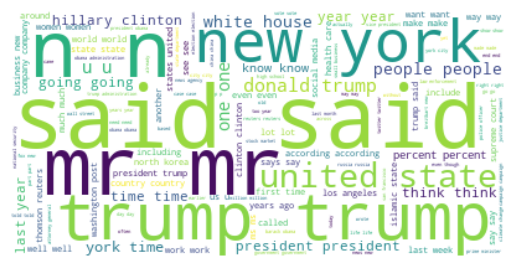

In [31]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(' '.join(news_dataset['keyphrases']))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [41]:
news_content = news_dataset['keyphrases']
    
# Apply NER
doc = nlp(news_content)

# Extract named entities
entities = [ent.text for ent in doc.ents]
    
entity_string = ' '.join(entities)
wordcloud = WordCloud(stopwords=stopwords).generate(entity_string)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


NameError: name 'nlp' is not defined

### Characterization

#### Pie Charts

- Source
- Publisher
- Year (use of the date of publication)

#### Histograms
alternative -> boxplots

- Length of news_dataset['content']

#### Heatmaps

- Year (use of the date of publication)

#### Scatter Plots

- ratio length over publication date